In [1]:
import sys
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import h5py  
import numpy as np
import os 
from scipy.misc import imresize
import cv2
import random
import soundfile as sf

In [2]:
class AudioDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, train, frames_len=40, transform=None, h5_file='/media/jeff/Backup/CS598PS/data_2682.h5', transform_label=None):
        """
        Args:
            train (bool): Whether or not to use training data
            frames (int): Number of video frames per video sample
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.train = train
        self.transform = transform
        self.frames_len = frames_len
        
        dataset = h5py.File(h5_file)
        if self.train:
            self.videos_train = np.array(dataset['videos_train'])
            self.sounds_train = np.array(dataset['sounds_train'])
        else:
            self.videos_test = np.array(dataset['videos_test'])
            self.sounds_test = np.array(dataset['sounds_test'])
        dataset.close()
        
    def __len__(self):
        if self.train:
            return len(self.videos_train)
        return len(self.videos_test)

    def __getitem__(self, idx):
        if self.train:
            image = self.videos_train[idx]
            audio = self.sounds_train[idx]
        else:
            image = self.videos_test[idx]
            audio = self.sounds_test[idx]

        # Randomly sample 4 seconds from 10 second clip
        if random.random() < 0.5:
            start = random.randint(0,10) # Start frame
        else:
            start = random.randint(50,60)
        new_image = np.zeros((self.frames_len,256,256,1), dtype=np.uint8)
        for i in range(self.frames_len):
            new_image[i] = np.expand_dims(image[start+i],2)
        
        # Randomly align or misalign audio sample
        if random.random() < 0.5: # align
            audio = audio[int(start*220500/100.0):int(start*220500/100.0)+88200]
            label = 0
        else: # misalign
            if start < 30: # Add shift
                shift = random.randint(20, 60-start) # frame shift amount
#                 start = np.clip(start+shift, 0, 100-self.frames_len)
                start = start+shift
            else: # Subtract shift
                shift = random.randint(20, start) # frame shift amount
#                 start = np.clip(start-shift, 0, 100-self.frames_len)
                start = start-shift
            audio = audio[int(start*220500/100.0):int(start*220500/100.0)+88200]
            label = 1
            
        transform_image = np.zeros((self.frames_len,1,224,224))
        if self.transform:
            for i in range(self.frames_len):
                transform_image[i] = self.transform(new_image[i]) # Transform image frames
        
        return (transform_image, audio, label)

In [3]:
import sys
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class Block2(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, kernel_size, stride, downsample=None):
        super(Block2, self).__init__()
        self.out_channels = out_channels
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=0, dilation=1, groups=1, bias=True)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Block3(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, kernel_size=(1,1,1), stride=1, downsample=None, padding=0):
        super(Block3, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding=padding, dilation=1, groups=1, bias=True)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=(1,1,1), stride=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out

def Linear(in_features, out_features, dropout=0.):
    m = nn.Linear(in_features, out_features)
    m.weight.data.normal_(mean=0, std=math.sqrt((1 - dropout) / in_features))
    m.bias.data.zero_()
    return nn.utils.weight_norm(m)

class alignment(nn.Module):
    def __init__(self):
        super(alignment, self).__init__()
        """Sound Features"""
        self.conv1_1 = nn.Conv1d(2, 64, 65, stride=4, padding=0, dilation=1, groups=1, bias=True)
        self.pool1_1 = nn.MaxPool1d(4, stride=4)

        self.s_net_1 = self._make_layer(Block2, 64, 128, 15, 4, 1)
        self.s_net_2 = self._make_layer(Block2, 128, 128, 15, 4, 1)
        self.s_net_3 = self._make_layer(Block2, 128, 256, 15, 4, 1)
        
        self.pool1_2 = nn.MaxPool1d(3, stride=3)
        self.conv1_2 = nn.Conv1d(256, 128, 3, stride=1, padding=0, dilation=1, groups=1, bias=True)
        
        """Image Features"""
        self.conv3_1 = nn.Conv3d(1, 64, (5,7,7), (2,2,2), padding=(2,3,3), dilation=1, groups=1, bias=True)
        self.pool3_1 = nn.MaxPool3d((1,3,3), (1,2,2), padding=(0,1,1))
        self.im_net_1 = self._make_layer(Block3, 64, 64, (3,3,3), (2,2,2), 2)

        """Fuse Features"""
        self.fractional_maxpool = nn.FractionalMaxPool2d((3,1), output_size=(10, 1))
        self.conv3_2 = nn.Conv3d(192, 512, (1, 1, 1))
        self.conv3_3 = nn.Conv3d(512, 128, (1, 1, 1))
        self.joint_net_1 = self._make_layer(Block3, 128, 128, (3,3,3), (2,2,2), 2)
        self.joint_net_2 = self._make_layer(Block3, 128, 256, (3,3,3), (1,2,2), 2)
        self.joint_net_3 = self._make_layer(Block3, 256, 512, (3,3,3), (1,2,2), 2)

        #TODO: Global avg pooling, fc and sigmoid
        self.fc = Linear(512,2)

    def _make_layer(self, block, in_channels, out_channels, kernel_size, stride, blocks):
        downsample = None
        if stride != 1 or in_channels != out_channels * block.expansion:
            if isinstance(kernel_size, int):
                downsample = nn.Sequential(
                    nn.Conv1d(in_channels, out_channels * block.expansion, kernel_size, stride),
                    nn.BatchNorm1d(out_channels * block.expansion),
                )
                layers = []
                layers.append(block(in_channels, out_channels, kernel_size, stride, downsample))
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(in_channels, out_channels * block.expansion, kernel_size, stride, padding=1),
                    nn.BatchNorm3d(out_channels * block.expansion),
                )
                layers = []
                layers.append(block(in_channels, out_channels, kernel_size, stride, downsample, padding=1))

        
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, sounds, images):
        batchsize = sounds.shape[0]
        sounds = sounds.view(batchsize, 2, -1)
        _, num, _, xd, yd, = images.shape
        images = images.view(batchsize, 1, num, xd, yd)
        
        out_s = self.conv1_1(sounds)
        out_s = self.pool1_1(out_s)

        out_s = self.s_net_1(out_s)
        out_s = self.s_net_2(out_s)
        out_s = self.s_net_3(out_s)

        out_s = self.pool1_2(out_s)
        out_s = self.conv1_2(out_s)
        
        out_im = self.conv3_1(images)
        out_im = self.pool3_1(out_im)
        out_im = self.im_net_1(out_im)

        #tile audio, concatenate channel wise
        out_s = self.fractional_maxpool(out_s.unsqueeze(3)) # Reduce dimension from 25 to 8
        out_s = out_s.squeeze(3).view(-1, 1, 1).repeat(1, 28, 28).view(-1,128,10,28,28) # Tile
        out_joint = torch.cat((out_s, out_im),1)
        out_joint = self.conv3_2(out_joint)
        out_joint = self.conv3_3(out_joint)
        out_joint = self.joint_net_1(out_joint)
        out_joint = self.joint_net_2(out_joint)
        out_joint = self.joint_net_3(out_joint)
        feature_maps = out_joint
        """Global Average Pooling"""
        out_joint = F.avg_pool3d(out_joint, kernel_size=out_joint.size()[2:]).view(batchsize,-1)
#         out_joint = out_joint.view(batchsize, 512, -1).mean(2)
        out_joint = self.fc(out_joint)
        out_joint = torch.sigmoid(out_joint)
        return out_joint, feature_maps

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

transform = transforms.Compose([
transforms.ToPILImage(),
# transforms.RandomHorizontalFlip(),
transforms.RandomCrop(224),
transforms.ToTensor()])

train_dataset = AudioDataset(train=True,transform=transform)
test_dataset = AudioDataset(train=False,transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=16, shuffle=False, num_workers=4)

model_align = alignment().cuda()
checkpoint = torch.load("fixed_500.pth")
model_align.load_state_dict(checkpoint.state_dict())

# Training

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer_align = optim.Adam(model_align.parameters(), lr = 1e-5)
for epoch in range(150):
    accs = []
    losses = []
    model_align.train()
    for batch_idx, (images, sounds, labels) in enumerate(train_loader):
        images_v = Variable(images.type(torch.FloatTensor)).cuda()
        sounds_v = Variable(sounds.type(torch.FloatTensor)).cuda()
        labels_v = Variable(labels).cuda()
        
        optimizer_align.zero_grad()
        aligned_res, _ = model_align(sounds_v, images_v)
        loss = loss_fn(aligned_res, labels_v)
        loss.backward()
        optimizer_align.step()
        losses.append(loss.item())
        accs.append(np.mean((torch.argmax(aligned_res,1) == labels_v).detach().cpu().numpy()))
    print("Epoch :", epoch, np.mean(losses), np.mean(accs))
    if (epoch + 1)%25 == 0:
        accs = []
        losses = []
        model_align.eval()
        for batch_idx, (images, sounds, labels) in enumerate(test_loader):
            with torch.no_grad():
                images_v = Variable(images.type(torch.FloatTensor)).cuda()
                sounds_v = Variable(sounds.type(torch.FloatTensor)).cuda()
                labels_v = Variable(labels).cuda()
                aligned_res, _ = model_align(sounds_v, images_v)
                loss = loss_fn(aligned_res, labels_v)
                losses.append(loss.item())
                accs.append(np.mean((torch.argmax(aligned_res,1) == labels_v).detach().cpu().numpy()))
        print("Validation :", epoch, np.mean(losses), np.mean(accs))
torch.save(model_align, 'larger_150.pth')

('Epoch :', 0, 0.69566239842346733, 0.50513392857142858)
('Epoch :', 1, 0.69309856813578374, 0.50825892857142863)
('Epoch :', 2, 0.6947832980326244, 0.49010416666666667)
('Epoch :', 3, 0.6938226474892526, 0.50290178571428568)
('Epoch :', 4, 0.69305693251746037, 0.50989583333333333)
('Epoch :', 5, 0.69422707493816105, 0.50081845238095235)
('Epoch :', 6, 0.69352869760422475, 0.50379464285714293)
('Epoch :', 7, 0.69387234002351761, 0.50230654761904758)
('Epoch :', 8, 0.69306198330152602, 0.51733630952380949)
('Epoch :', 9, 0.69413759275561282, 0.48511904761904762)
('Epoch :', 10, 0.69390148527565454, 0.49293154761904762)
('Epoch :', 11, 0.69318466314247673, 0.5055803571428571)
('Epoch :', 12, 0.69401161408140544, 0.48958333333333331)
('Epoch :', 13, 0.69360124355270747, 0.50327380952380951)
('Epoch :', 14, 0.69369949542340781, 0.50409226190476186)
('Epoch :', 15, 0.69321054504031232, 0.5011160714285714)
('Epoch :', 16, 0.69367491595801856, 0.49895833333333334)
('Epoch :', 17, 0.6932206937

('Epoch :', 137, 0.69349050486371633, 0.49583333333333329)
('Epoch :', 138, 0.69332038220905123, 0.50535714285714284)
('Epoch :', 139, 0.69307814999705264, 0.51034226190476184)
('Epoch :', 140, 0.69305345380590078, 0.51026785714285716)
('Epoch :', 141, 0.69288140287001931, 0.49977678571428574)
('Epoch :', 142, 0.69359347791898818, 0.4991071428571428)
('Epoch :', 143, 0.69329587689467842, 0.49605654761904766)
('Epoch :', 144, 0.69334830272765391, 0.49680059523809528)
('Epoch :', 145, 0.69309604238896139, 0.50252976190476184)
('Epoch :', 146, 0.69325747163522811, 0.48742559523809526)
('Epoch :', 147, 0.69330819376877373, 0.49233630952380958)
('Epoch :', 148, 0.69322749475638068, 0.49873511904761902)
('Epoch :', 149, 0.69326861309153698, 0.49099702380952381)
('Validation :', 149, 0.69342951591198265, 0.48782051282051281)


/usr/local/lib/python2.7/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type alignment. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python2.7/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Block2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python2.7/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Block3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Feature Map Visualization

In [7]:
def activation(feature_map, weights, label):
    output = np.zeros((224,224))
    for i in range(512):
        output += imresize(feature_map[i], (224,224))*weights[label,i]
    return output

In [8]:
for name, param in model_align.state_dict().items():
    if name =='fc.weight_v':
        weight = param

In [9]:
images, sounds, labels = train_dataset[37]
images_v = Variable(torch.tensor(images)).type(torch.FloatTensor).cuda().unsqueeze(0)
sounds_v = Variable(torch.tensor(sounds)).type(torch.FloatTensor).cuda().unsqueeze(0)
labels_v = Variable(torch.tensor(labels)).cuda().unsqueeze(0)
aligned_res, feature_maps = model_align(sounds_v, images_v)

In [10]:
output = activation(feature_maps[0,:,0].detach().cpu().numpy(), weight.detach().cpu().numpy(),0)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


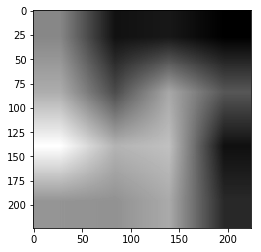

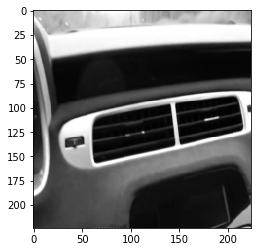

In [11]:
plt.imshow(output, cmap='gray')
plt.show()
plt.imshow(images[0,0], cmap='gray')

In [71]:
np.unique(output)

array([-367.36499567, -367.35861125, -367.14408086, ...,    8.636785  ,
          8.67113671,    8.9101118 ])